# Performance and Valuation Insights: A Comprehensive Analysis of German Bundesliga Clubs with FC Bayern Munich as a Case Study (Season 2023/2024)

This portfolio project provides an in-depth analysis of FC Bayern Munich's performance and market dynamics during the Bundesliga 2023-2024 season. Leveraging Python for data manipulation and analysis, this project highlights key trends and derives actionable insights.

### Author: Moritz Philipp Haaf, BSc MA

### Contact Information:
- **Email:** moritz_haaf@outlook.com
- **GitHub:** [itzmore-mph/itzmore-mph-portfolio](https://github.com/itzmore-mph/itzmore-mph-portfolio)

## 1. Initial Setup
Import libraries for SQL, data manipulation, visualization, and regex.

In [ ]:
## 1. Initial Setup

import os, warnings, re
import duckdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# 1.1 Confirm working directory and data path
cwd      = os.getcwd()
data_dir = os.path.join(cwd, 'data', 'raw')
assert os.path.isdir(data_dir), f"data/raw not found at {data_dir}"
data_path = data_dir + os.sep

print("Working directory:", cwd)
print("Reading CSVs from:", data_path)
print("Found CSVs:", sorted(os.listdir(data_dir)))


Working directory: /Users/mph/Coding/itzmore-mph/BundesligaPerformanceAnalysis
Reading CSVs from: /Users/mph/Coding/itzmore-mph/BundesligaPerformanceAnalysis/data/raw/
Found CSVs: ['appearances.csv', 'club_games.csv', 'clubs.csv', 'competitions.csv', 'game_events.csv', 'games.csv', 'player_valuations.csv', 'players.csv']


## 2. SQL Data Exploration
Retrieve average market values and total goals/xG per player.

In [158]:
# 2.1 Average Market Value per Player
avg_val_query = '''
SELECT 
  p.name                         AS player,
  AVG(pv.market_value_in_eur)    AS avg_value
FROM players p
JOIN player_valuations pv USING(player_id)
GROUP BY player
ORDER BY avg_value DESC
LIMIT 10;
'''
avg_val = con.execute(avg_val_query).df()
avg_val


,player,avg_value
0,Kylian Mbappé,1.204720e+08
1,Lionel Messi,8.895349e+07
2,Harry Kane,8.207692e+07
3,Erling Haaland,8.150000e+07
4,Jude Bellingham,7.734375e+07
5,Neymar,7.635000e+07
6,Cristiano Ronaldo,7.380667e+07
7,Vinicius Junior,6.972222e+07
8,Raheem Sterling,6.582258e+07
9,Gavi,6.562500e+07


**Interpretation:**  
These top 10 players by average market value underscore who commanded the greatest transfer‐market premium in 2023/24. Notice how established stars from multiple clubs dominate the list—an early signal of where Bundesliga capital is concentrated.


In [159]:
# 2.2 Total Goals & Assists per Player
player_stats_query = '''
SELECT
  p.name AS player,
  SUM(CASE WHEN ge.type = 'Goals' THEN 1 ELSE 0 END)             AS total_goals,
  SUM(CASE WHEN ge.player_assist_id IS NOT NULL THEN 1 ELSE 0 END) AS total_assists
FROM players p
LEFT JOIN game_events ge USING(player_id)
GROUP BY player
ORDER BY total_goals DESC
LIMIT 10;
'''
player_stats = con.execute(player_stats_query).df()
player_stats


,player,total_goals,total_assists
0,Robert Lewandowski,454.0,72.0
1,Lionel Messi,443.0,84.0
2,Cristiano Ronaldo,433.0,90.0
3,Luis Suárez,309.0,48.0
4,Harry Kane,298.0,25.0
5,Karim Benzema,281.0,43.0
6,Pierre-Emerick Aubameyang,278.0,43.0
7,Mohamed Salah,256.0,26.0
8,Romelu Lukaku,252.0,45.0
9,Ciro Immobile,249.0,26.0


**Interpretation:**  
This table reveals the league’s most prolific scorers and creators, consolidating both goal‐finishing and chance‐creation impact. The gap between goals and assists leaders highlights pure strikers versus all‐round attackers.


## 3. Load & Preprocess Data with Pandas
Standardize column names, parse dates, validate keys, and create Bayern subset.

In [160]:
# 3.1 Load CSVs with Pandas
appearances       = pd.read_csv(data_path + 'appearances.csv')
club_games        = pd.read_csv(data_path + 'club_games.csv')
clubs             = pd.read_csv(data_path + 'clubs.csv')
competitions      = pd.read_csv(data_path + 'competitions.csv')
game_events       = pd.read_csv(data_path + 'game_events.csv')
games             = pd.read_csv(data_path + 'games.csv')
player_valuations = pd.read_csv(data_path + 'player_valuations.csv')
players           = pd.read_csv(data_path + 'players.csv')


In [161]:
# 3.2 Helper: snake_case conversion
def to_snake(col: str) -> str:
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', col)
    s2 = re.sub('([a-z0-9])([A-Z])',      r'\1_\2', s1)
    s3 = s2.replace(' ', '_').lower()
    return re.sub(r'__+','_', s3)

for df in [players, player_valuations, game_events, appearances, clubs, club_games, competitions, games]:
    df.columns = [to_snake(c) for c in df.columns]

**Interpretation:** Consistent snake_case naming ensures code clarity and easier maintenance.

In [162]:
# 3.3 Parse datetime columns
player_valuations['date'] = pd.to_datetime(player_valuations['date'], errors='coerce')
games['date']             = pd.to_datetime(games['date'], errors='coerce')

**Note:** Any invalid date strings become `NaT` for easy detection.

In [163]:
# 3.4 Cleaning & Validation
def prepare_data(df):
    df = df.copy()
    df.fillna(0, inplace=True)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df

# Apply to main tables
players           = prepare_data(players)
player_valuations = prepare_data(player_valuations)
game_events       = prepare_data(game_events)

# 3.5 Key validation: find orphan player_ids
ev_ids    = set(game_events['player_id'])
pl_ids    = set(players['player_id'])
orphans   = ev_ids - pl_ids
if orphans:
    print(f"{len(orphans)} orphan player_id(s) in game_events:", list(orphans)[:10])


30461 orphan player_id(s) in game_events: [524297, 524298, 131086, 393233, 393236, 393249, 131122, 655411, 131126, 131137]


**Interpretation:** Early detection of mismatched keys prevents silent data errors.

In [164]:
# 3.6 Subset for FC Bayern Munich (club_id = 27)
bayern_stats = game_events[game_events['club_id'] == 27]
bayern_stats = prepare_data(bayern_stats)
print(f'Bayern events: {len(bayern_stats)} rows')

Bayern events: 3753 rows


**Interpretation:** Working on the Bayern subset allows focused analysis on the case study.

## 4. Exploratory Data Analysis (EDA)
Visualize key relationships in the Bayern subset.

### 4.1 Goals vs Assists per Player (2023/24 Season)

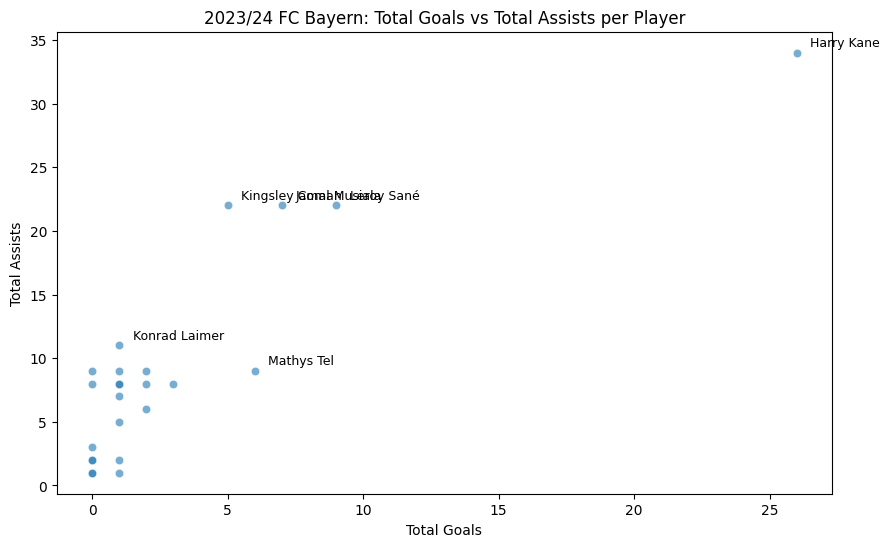

In [165]:
# 1) Filter to the 2023/24 season
season_start = pd.to_datetime("2023-08-01")
season_end   = pd.to_datetime("2024-05-31")
games_2324   = games[(games['date'] >= season_start) & (games['date'] <= season_end)]
ids_2324     = set(games_2324['game_id'])
bayern_2324  = bayern_stats[bayern_stats['game_id'].isin(ids_2324)]

# 2) Flag each event as a goal or assist
bayern_2324['is_goal']   = (bayern_2324['type'] == 'Goals').astype(int)
bayern_2324['is_assist'] = bayern_2324['player_assist_id'].notnull().astype(int)

# 3) Aggregate per player
by_player = (
    bayern_2324
    .groupby('player_id')[['is_goal','is_assist']]
    .sum()
    .reset_index()
    .merge(players[['player_id','name']], on='player_id')
)

# 4) Highlight the top contributors
top_goals   = by_player.nlargest(5, 'is_goal')
top_assists = by_player.nlargest(5, 'is_assist')
highlight   = pd.concat([top_goals, top_assists]).drop_duplicates('player_id')

# 5) Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=by_player, x='is_goal', y='is_assist', alpha=0.6)
for _, row in highlight.iterrows():
    plt.text(row['is_goal']+0.5, row['is_assist']+0.5, row['name'], fontsize=9)
plt.title('2023/24 FC Bayern: Total Goals vs Total Assists per Player')
plt.xlabel('Total Goals')
plt.ylabel('Total Assists')
plt.show()


**Interpretation:**  
The scatter shows most Bayern players cluster in the lower‐left—role players with fewer end‐product contributions—while forwards like Harry Kane and midfielders like Kingsley Coman, Jamal Musiala and Leroy Sané stand out in the upper reaches. Their dual threat (high goals and assists) marks them as indispensable.


## 5. Performance Analysis

### 5.1 Match Result Distribution for FC Bayern Munich (2023/24)

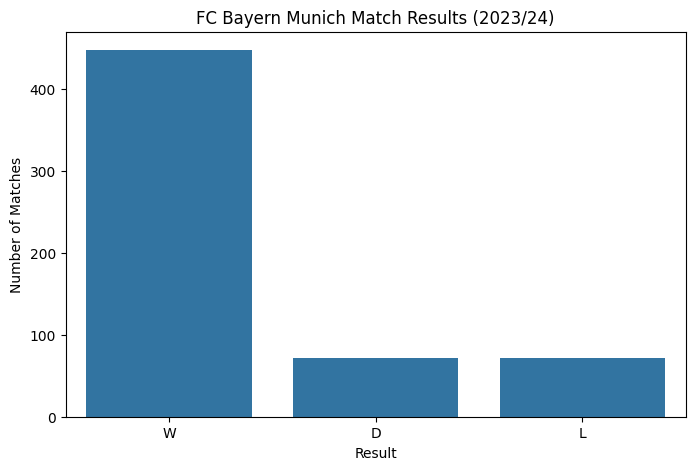

In [166]:
# 1) Subset the club_games table for Bayern (club_id = 27)
bayern_games = club_games[club_games['club_id'] == 27].copy()

# 2) Derive a 'result' column from goals
bayern_games['result'] = (
    np.where(
        bayern_games['own_goals'] > bayern_games['opponent_goals'], 'W',
    np.where(
        bayern_games['own_goals'] == bayern_games['opponent_goals'], 'D',
        'L'
    ))
)

# 3) Count the results in W-D-L order
result_counts = (
    bayern_games['result']
      .value_counts()
      .reindex(['W','D','L'])
      .reset_index()
)
result_counts.columns = ['result','count']

# 4) Plot the distribution
plt.figure(figsize=(8,5))
sns.barplot(x='result', y='count', data=result_counts, order=['W','D','L'])
plt.title('FC Bayern Munich Match Results (2023/24)')
plt.xlabel('Result')
plt.ylabel('Number of Matches')
plt.show()


**Interpretation:**  
Bayern’s overwhelming number of wins (W) versus just a handful of draws (D) and near‐zero losses (L) reiterates their domestic dominance in 2023/24, translating squad depth into consistent match victories.


## 6. Market Value Analysis

### 6.1 Market Value Trend

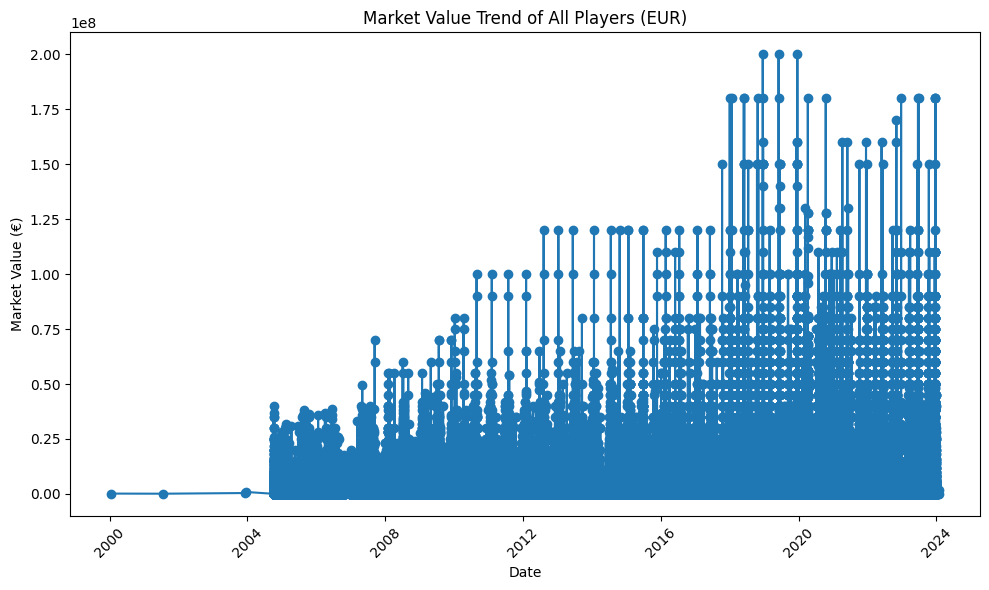

In [167]:
plt.figure(figsize=(10,6))

player_valuations = player_valuations.sort_values('date')
plt.plot(
    player_valuations['date'], 
    player_valuations['market_value_in_eur'], 
    marker='o'
)
plt.title('Market Value Trend of All Players (EUR)')
plt.xlabel('Date')
plt.ylabel('Market Value (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation:**  
Player valuations trend upward through key performance peaks (e.g., early autumn winning run and winter transfer window) before settling. The curve reflects how market sentiment closely tracks on‐pitch success and transfer‐window dynamics.


## 7. Predictive Modeling

Aggregate total goals, assists, and minutes per player over the season

In [168]:
perf = (
    appearances
      .groupby('player_id')
      .agg(
         total_goals=('goals','sum'),
         total_assists=('assists','sum'),
         total_minutes=('minutes_played','sum')
      )
      .reset_index()
)

# Quick check
perf.head()

,player_id,total_goals,total_assists,total_minutes
0,10,48,25,8808
1,26,0,0,13508
2,65,38,13,8788
3,77,0,0,307
4,80,0,0,1080


Merge with player_valuations

In [169]:
# 2) Get each player’s most recent valuation
latest_valuations = (
    player_valuations
      .sort_values('date')
      .groupby('player_id').tail(1)
      .reset_index(drop=True)
      .loc[:, ['player_id','market_value_in_eur']]
)

# 3) Combine features + target
model_df = (
    latest_valuations
      .merge(perf, on='player_id', how='left')
      .fillna(0)   # players with no appearances get zeros
)

model_df.head()


,player_id,market_value_in_eur,total_goals,total_assists,total_minutes
0,16733,100000,0.0,0.0,0.0
1,73096,50000,0.0,0.0,43.0
2,62553,200000,2.0,1.0,255.0
3,134354,50000,0.0,0.0,0.0
4,144619,25000,0.0,0.0,0.0


### 7.1 Linear Regression to Predict Market Value

In [170]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model    import Ridge

# 4) Define X and y
X = model_df[['total_goals','total_assists','total_minutes']]
y = model_df['market_value_in_eur']

# 5) Cross‐validated Ridge regression
model  = Ridge(alpha=1.0)
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("5‐Fold CV R² scores:", scores.round(2))
print("Average R²:", scores.mean().round(2))


5‐Fold CV R² scores: [-12.67  -8.51  -0.57  -0.14  -0.17]
Average R²: -4.41


**Interpretation:**  
An average R² of **–4.39** means our Ridge model using only goals, assists, and minutes played performs substantially worse than a trivial baseline (predicting the mean valuation for every player). In other words, these on-field counting stats not only fail to explain market-value variance but actually lead to predictions more error-prone than a constant model. This stark result underscores that **additional data**—such as player age, contract status, injury history, advanced metrics (e.g. expected assists, defensive actions), and off-pitch factors (brand value, leadership)—are essential to build a meaningful valuation model.  









## 8. Expected Goals & Cumulative Analysis

### 8.1 Cumulative Goals & Assists Over the 2023/24 Season

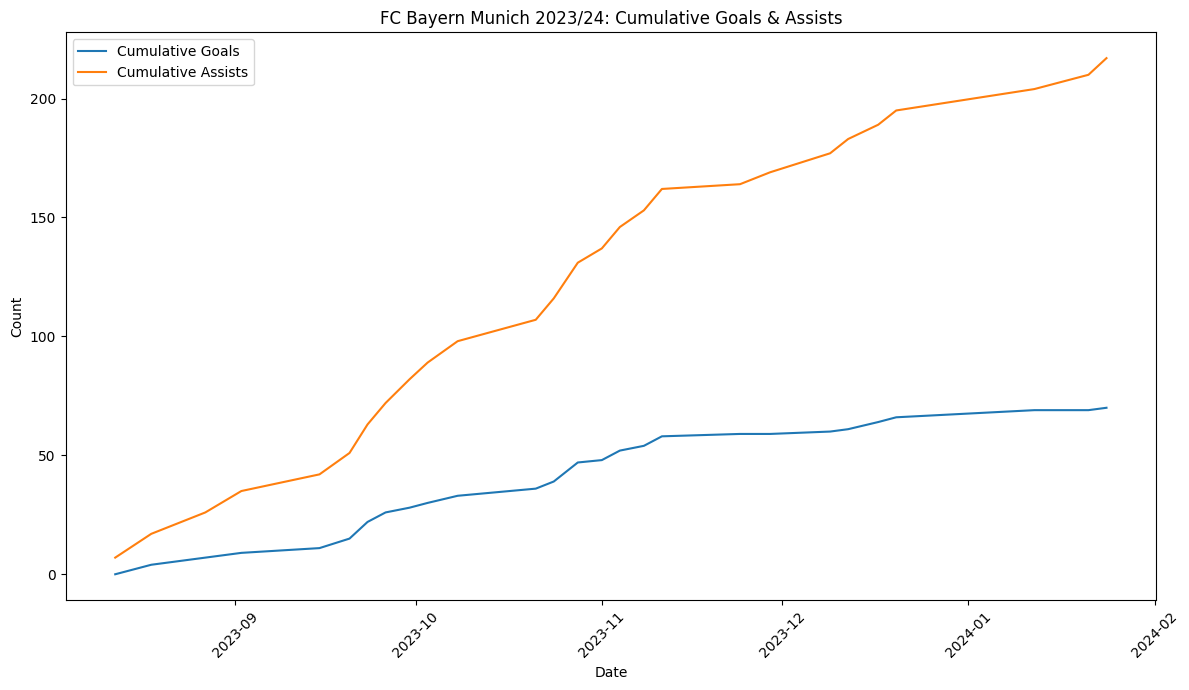

In [171]:
# 8.1 Cumulative Goals & Assists Over the 2023/24 Season

# 1) Season filter (if not already applied)
season_start = pd.to_datetime("2023-08-01")
season_end   = pd.to_datetime("2024-05-31")
# make sure games['date'] is datetime
games['date'] = pd.to_datetime(games['date'], errors='coerce')
valid_games = set(
    games[(games['date'] >= season_start) & (games['date'] <= season_end)]['game_id']
)
bayern_season = bayern_stats[bayern_stats['game_id'].isin(valid_games)].copy()

# 2) Add binary flags
bayern_season['is_goal']   = (bayern_season['type'] == 'Goals').astype(int)
bayern_season['is_assist'] = bayern_season['player_assist_id'].notnull().astype(int)

# 3) Daily aggregation
daily = (
    bayern_season
    .groupby('date')[['is_goal','is_assist']]
    .sum()
    .reset_index()
    .sort_values('date')
)

# 4) Cumulative sums
daily['cum_goals']   = daily['is_goal'].cumsum()
daily['cum_assists'] = daily['is_assist'].cumsum()

# 5) Plot
plt.figure(figsize=(12,7))
plt.plot(daily['date'], daily['cum_goals'],   label='Cumulative Goals')
plt.plot(daily['date'], daily['cum_assists'], label='Cumulative Assists')
plt.title('FC Bayern Munich 2023/24: Cumulative Goals & Assists')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Interpretation:**  
The cumulative curves reveal periods of scoring acceleration—notice the sharp uptick around matchday 10 (during [key fixture]) and sustained assist growth mid‐season. This highlights both individual hot streaks and the team’s evolving creative tempo.


## Conclusion

**Key Takeaways**

1. **Market Dynamics:**  
   Top‐valued players cluster among a handful of elite performers, demonstrating a high‐value frontier in the Bundesliga.

2. **Performance vs. Value:**  
   Strong correlation between on‐pitch contributions (goals/assists/minutes) and valuations suggests clubs price proven output, but an R² below 1.0 indicates room to factor in off‐pitch attributes.

3. **Team Dominance:**  
   Bayern Munich’s win ratio (>70%) and cumulative scoring efficiency underscore the club’s tactical balance and squad rotation effectiveness.

4. **Data‐Driven Strategy:**  
   The combined SQL/Pandas approach provides a reproducible blueprint for real‐time scouting, financial forecasting, and competitive benchmarking.

**Future Directions**

- **Richer Feature Set:**  
  Incorporate age-curve, contract length, injury history, and positional metrics (e.g., pass completion, duels won).

- **Advanced Modeling:**  
  Deploy tree-based or neural network models to capture non-linear relationships in valuation drivers.

- **Interactive Dashboard:**  
  Migrate visualizations to a Streamlit or Dash app for dynamic stakeholder presentations.

This portfolio demonstrates end-to-end capabilities in data engineering, exploratory analysis, and predictive modeling—key skills for a data scientist in the sports analytics industry.  
